<a href="https://colab.research.google.com/github/ikikika/data_science/blob/digit_recognizer-kaggle/digit_recognizer/digit_recognizer1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Digit Recognizer

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

sns.set( style='white', context='notebook', palette='deep' )

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


## Data

### Load Data

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ikikika","key":"58b37dbfd627308d2ee21d09aaff608d"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [5]:
!kaggle competitions list

ref                                            deadline             category            reward  teamCount  userHasEntered  
---------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
tpu-getting-started                            2030-06-03 23:59:00  Getting Started      Kudos        166           False  
digit-recognizer                               2030-01-01 00:00:00  Getting Started  Knowledge       2947           False  
titanic                                        2030-01-01 00:00:00  Getting Started  Knowledge      22642            True  
house-prices-advanced-regression-techniques    2030-01-01 00:00:00  Getting Started  Knowledge       4995            True  
connectx                                       2030-01-01 00:00:00  Getting Started  Knowledge        710           False  
nlp-getting-started                            2030-01-01 00:00:00  Getting Started      Kudos       1487           False  
competit

In [6]:
!kaggle competitions download -c digit-recognizer

 55% 5.00M/9.16M [00:00<00:00, 25.1MB/s]
100% 9.16M/9.16M [00:00<00:00, 36.3MB/s]
  0% 0.00/235k [00:00<?, ?B/s]
100% 235k/235k [00:00<00:00, 74.7MB/s]
 82% 5.00M/6.09M [00:00<00:00, 24.8MB/s]
100% 6.09M/6.09M [00:00<00:00, 24.2MB/s]


In [7]:
!unzip -q "../content/train.csv.zip"
!unzip -q "../content/test.csv.zip"

In [8]:
train = pd.read_csv("../content/train.csv")
test = pd.read_csv("../content/test.csv")

In [9]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

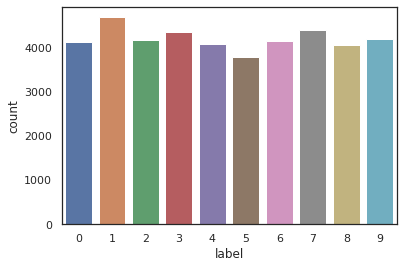

In [11]:
y_train = train["label"]

# Drop 'label' column
x_train = train.drop( labels=["label"], axis=1 )

# Free some space
del train

g = sns.countplot(y_train)

y_train.value_counts()

In [12]:
x_train.shape

(42000, 784)

In [13]:
y_train.shape

(42000,)

### Check for null or missing values

In [14]:
# Check data
x_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [15]:
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

No missing value in train and test datasets

### Normalisation
We perform a grayscale normalisation to reduce the effect of illumination differences.

Moreover the CNN faster on [0...1] data than on [0...255]

In [16]:
# Normalise the data
x_train = x_train / 255
test = test / 255

### Reshape

In [17]:
# Reshape image in 3 dimensions (height = 28px, widht=28px, canal =1)
x_train = x_train.values.reshape(-1, 28, 28, 1)
test = test.values.reshape(-1, 28, 28, 1)

Train and test images (28px x 28px) has been stocked into pandas.DataFrame as 1D vectors of 784 values.

We reshape all datga to 28x28x1 3D matrices.

Keras requries an extra dimension in the end which correspond to channels.

MNIST images are gray scaled so it use only 1 channel.

FOr RGB images, there are 3 channels, we sould have reshaped 784px vectors to 28x28x3 3D matrices.

### Label Encoding

In [18]:
# Encode labels to one hot vectors (eg, 2 -> [0,0,1,0,0,0,0,0,0])
y_train = to_categorical( y_train, num_classes=10 )

### Split training and validation set

In [19]:
# Set random seed
random_seed = 2

In [21]:
# Split train and validation set for fitting
x_train, x_val, y_train, y_val = train_test_split( x_train, y_train, test_size=0.1, random_state=random_seed )

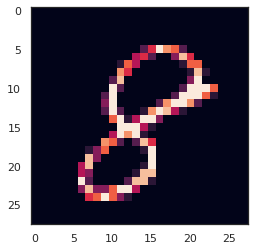

In [22]:
# Some examples
g = plt.imshow( x_train[0][:,:,0] )